In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from datetime import datetime, timedelta
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/HistoricalQuotes.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [4]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [5]:
df.columns = df.columns.str.strip()

In [6]:
# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Dataset shape: (2518, 6)
Columns: ['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']
        Date Close/Last     Volume       Open       High        Low
0 2010-03-01   $29.8557  137312041   $29.3928   $29.9286     $29.35
1 2010-03-02   $29.8357  141486282     $29.99   $30.1186   $29.6771
2 2010-03-03   $29.9043   92846488   $29.8486   $29.9814   $29.7057
3 2010-03-04   $30.1014   89591907   $29.8971   $30.1314   $29.8043
4 2010-03-05   $31.2786  224647427   $30.7057   $31.3857   $30.6614


In [7]:
# Clean and prepare price data
# Handle different possible column names for Close price
close_col = None
for col in ['Close/Last', 'Close', 'close']:
    if col in df.columns:
        close_col = col
        break

if close_col is None:
    print("Error: Could not find Close price column")
    exit()

# Remove $ signs and convert to numeric if needed
if df[close_col].dtype == 'object':
    df[close_col] = df[close_col].str.replace('$', '').astype(float)

# Do the same for other price columns
price_cols = ['Open', 'High', 'Low', 'Volume']
for col in price_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)

# Create Close column for consistency
df['Close'] = df[close_col]

# Calculate next day's price change percentage
df['Next_Day_Close'] = df['Close'].shift(-1)
df['Price_Change_Pct'] = (df['Next_Day_Close'] - df['Close']) / df['Close']

In [8]:
# Multi-class classification with threshold
threshold = 0.01  # 1% threshold

df['Price_Direction'] = np.where(df['Price_Change_Pct'] > threshold, 2,      # Up
                                np.where(df['Price_Change_Pct'] < -threshold, 0, 1))  # Down, Sideways

# Create labels for better interpretation
direction_labels = {0: 'Down', 1: 'Sideways', 2: 'Up'}
df['Direction_Label'] = df['Price_Direction'].map(direction_labels)

print("\nMulti-Class Price Direction Distribution:")
print(df['Price_Direction'].value_counts().sort_index())
print("\nPercentage Distribution:")
print(df['Price_Direction'].value_counts(normalize=True).sort_index())

# Technical indicators
df['Price_Change'] = df['Close'].pct_change()
df['Volume_Change'] = df['Volume'].pct_change()

# Moving averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['Price_Above_SMA5'] = (df['Close'] > df['SMA_5']).astype(int)
df['Price_Above_SMA10'] = (df['Close'] > df['SMA_10']).astype(int)

# Volatility indicators
df['Volatility'] = df['Price_Change'].rolling(window=5).std()
df['High_Low_Ratio'] = df['High'] / df['Low']
df['Open_Close_Ratio'] = df['Open'] / df['Close']

# Price position within the day's range
df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

# Previous day's performance
df['Prev_Day_Up'] = (df['Close'] > df['Close'].shift(1)).astype(int)
df['Prev_Day_Volume'] = df['Volume'].shift(1)

# Momentum indicators
df['Price_Momentum_3'] = df['Close'] / df['Close'].shift(3)
df['Volume_Momentum_3'] = df['Volume'] / df['Volume'].shift(3)

print("Features created successfully!")

# Select relevant features for direction prediction
features = [
    'Open', 'High', 'Low', 'Volume',
    'Price_Change', 'Volume_Change',
    'Price_Above_SMA5', 'Price_Above_SMA10',
    'Volatility', 'High_Low_Ratio', 'Open_Close_Ratio',
    'Price_Position', 'Prev_Day_Up',
    'Price_Momentum_3', 'Volume_Momentum_3'
]

# Remove rows with NaN values
df_clean = df.dropna()
print(f"Dataset shape after cleaning: {df_clean.shape}")

# Prepare features and target
X = df_clean[features]
y = df_clean['Price_Direction']

print(f"Final features shape: {X.shape}")
print(f"Multi-class target distribution after cleaning:")
print(y.value_counts(normalize=True).sort_index())

# Time-based split (important for time series)
split_index = int(len(df_clean) * 0.75)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"\nTraining set: {X_train.shape[0]} samples (80%)")
print(f"Test set: {X_test.shape[0]} samples (20%)")

# Create decision tree classifier for multi-class
model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)


Multi-Class Price Direction Distribution:
Price_Direction
0     468
1    1428
2     622
Name: count, dtype: int64

Percentage Distribution:
Price_Direction
0    0.185862
1    0.567117
2    0.247021
Name: proportion, dtype: float64
Features created successfully!
Dataset shape after cleaning: (2508, 25)
Final features shape: (2508, 15)
Multi-class target distribution after cleaning:
Price_Direction
0    0.186603
1    0.566188
2    0.247209
Name: proportion, dtype: float64

Training set: 1881 samples (80%)
Test set: 627 samples (20%)


In [9]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Multi-class model trained successfully!")

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_test_cv = X.iloc[test_idx]
    y_train_cv = y.iloc[train_idx]
    y_test_cv = y.iloc[test_idx]
    
    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_test_cv)
    cv_scores.append(accuracy_score(y_test_cv, y_pred_cv))

print(f"\nCross-validation accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

Multi-class model trained successfully!

Cross-validation accuracy: 0.4115 (±0.0757)


In [ ]:
# Model evaluationed
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# Check what classes are actually present
unique_test_classes = np.unique(y_test)
unique_pred_classes = np.unique(y_pred)
all_classes = np.unique(np.concatenate([y_test, y_pred]))

print(f"Classes in test set: {unique_test_classes}")
print(f"Classes in predictions: {unique_pred_classes}")

# Define all possible target names
target_names_full = ['Down', 'Sideways', 'Up']

# Detailed classification report - let sklearn handle the classes automatically
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Get the labels that are actually present for the confusion matrix
cm_labels = np.unique(np.concatenate([y_test, y_pred]))
print("Labels: " + " ".join([f"{target_names_full[i]:>8}" for i in cm_labels]))

for i, actual_class in enumerate(cm_labels):
    class_name = target_names_full[actual_class]
    print(f"{class_name:>6}: {cm[i]}")

# Class-specific metrics
print("\nClass-specific Performance:")
for class_idx in cm_labels:
    class_name = target_names_full[class_idx]
    
    # Find the position of this class in the confusion matrix
    pos = np.where(cm_labels == class_idx)[0][0]
    
    # Calculate precision and recall
    true_positives = cm[pos, pos]
    predicted_positives = cm[:, pos].sum()
    actual_positives = cm[pos, :].sum()
    
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    
    print(f"{class_name}: Precision={precision:.4f}, Recall={recall:.4f}")

# Trading strategy analysis
print("\nTrading Strategy Analysis:")

# UP predictions (class 2)
up_predictions = (y_pred == 2)
if up_predictions.sum() > 0:
    up_accuracy = (y_test[up_predictions] == 2).mean()
    print(f"When predicting UP: Accuracy = {up_accuracy:.4f} ({up_predictions.sum()} predictions)")
else:
    print("No UP predictions made")

# DOWN predictions (class 0)
down_predictions = (y_pred == 0)
if down_predictions.sum() > 0:
    down_accuracy = (y_test[down_predictions] == 0).mean()
    print(f"When predicting DOWN: Accuracy = {down_accuracy:.4f} ({down_predictions.sum()} predictions)")
else:
    print("No DOWN predictions made")

# SIDEWAYS predictions (class 1)
sideways_predictions = (y_pred == 1)
if sideways_predictions.sum() > 0:
    sideways_accuracy = (y_test[sideways_predictions] == 1).mean()
    print(f"When predicting SIDEWAYS: Accuracy = {sideways_accuracy:.4f} ({sideways_predictions.sum()} predictions)")
else:
    print("No SIDEWAYS predictions made")

# High confidence predictions
max_proba = y_pred_proba.max(axis=1)
high_confidence = max_proba > 0.6

if high_confidence.sum() > 0:
    high_conf_accuracy = (y_test[high_confidence] == y_pred[high_confidence]).mean()
    print(f"High confidence predictions (>60%): Accuracy = {high_conf_accuracy:.4f}")
    print(f"High confidence predictions: {high_confidence.sum()}/{len(y_test)} = {high_confidence.mean():.2%}")
else:
    print("No high confidence predictions")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Recent predictions
if len(X_test) >= 5:
    last_5_days = X_test.tail(5)
    predictions = model.predict(last_5_days)
    probabilities = model.predict_proba(last_5_days)
    
    # Check the shape of probabilities and model classes
    print(f"Model classes: {model.classes_}")
    print(f"Probability shape: {probabilities.shape}")
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Date': df_clean['Date'].iloc[-5:].values,
        'Actual_Close': df_clean['Close'].iloc[-5:].values,
        'Predicted_Direction': [target_names_full[p] for p in predictions],
        'Actual_Direction': [target_names_full[a] for a in y_test.tail(5)]
    })
    
    # Add probability columns based on what classes the model actually has
    for i, class_idx in enumerate(model.classes_):
        results[f'Prob_{target_names_full[class_idx]}'] = probabilities[:, i]
    
    print("\nRecent Multi-Class Predictions:")
    print(results.round(3))

# Future predictions
last_date = df_clean['Date'].iloc[-1]
print(f"\nLast date in dataset: {last_date}")

future_dates = []
for i in range(1, 6):
    future_date = last_date + timedelta(days=i)
    future_dates.append(future_date)

# Use last available features for prediction
last_features = X_test.iloc[-1:].values
predictions = model.predict([last_features[0]] * 5)
probabilities = model.predict_proba([last_features[0]] * 5)

# Create future results DataFrame
future_results = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Direction': [target_names_full[p] for p in predictions]
})

# Add probability columns based on model's actual classes
for i, class_idx in enumerate(model.classes_):
    future_results[f'Prob_{target_names_full[class_idx]}'] = probabilities[:, i]

print("\nFuture Predictions:")
print(future_results.round(3))

# Diagnostic information
print("\nDiagnostic Information:")
print(f"Model was trained on classes: {model.classes_}")
print(f"Model probability output shape: {probabilities.shape}")
print(f"Class distribution in test set:")
for class_idx in range(3):
    count = (y_test == class_idx).sum()
    percentage = count / len(y_test) * 100 if len(y_test) > 0 else 0
    print(f"  {target_names_full[class_idx]} (class {class_idx}): {count} ({percentage:.1f}%)")

print(f"Class distribution in predictions:")
for class_idx in range(3):
    count = (y_pred == class_idx).sum()
    percentage = count / len(y_pred) * 100 if len(y_pred) > 0 else 0
    print(f"  {target_names_full[class_idx]} (class {class_idx}): {count} ({percentage:.1f}%)")

Overall Accuracy: 0.2951
Classes in test set: [0 1 2]
Classes in predictions: [0 1 2]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.36      0.22       117
           1       0.60      0.24      0.34       351
           2       0.27      0.38      0.32       159

    accuracy                           0.30       627
   macro avg       0.34      0.32      0.29       627
weighted avg       0.43      0.30      0.31       627


Confusion Matrix:
Labels:     Down Sideways       Up
  Down: [42 19 56]
Sideways: [163  83 105]
    Up: [63 36 60]

Class-specific Performance:
Down: Precision=0.1567, Recall=0.3590
Sideways: Precision=0.6014, Recall=0.2365
Up: Precision=0.2715, Recall=0.3774

Trading Strategy Analysis:
When predicting UP: Accuracy = 0.2715 (221 predictions)
When predicting DOWN: Accuracy = 0.1567 (268 predictions)
When predicting SIDEWAYS: Accuracy = 0.6014 (138 predictions)
High confidence predictions (>60%): Accuracy

In [11]:
# Get the classes that are actually present in the confusion matrix
present_classes = np.unique(np.concatenate([y_test, y_pred]))
print(f"Classes present in data: {present_classes}")
print(f"Confusion matrix shape: {cm.shape}")

# Calculate overall accuracy
total_predictions = cm.sum()
correct_predictions = np.trace(cm)
accuracy = correct_predictions / total_predictions

print(f"Overall accuracy: {accuracy:.4f}")

# Calculate trading-specific metrics safely
class_names = ['Down', 'Sideways', 'Up']

# Initialize counters
up_predictions = 0
down_predictions = 0
sideways_predictions = 0

# Count predictions for each class that exists
for i, class_idx in enumerate(present_classes):
    predictions_for_class = cm[:, i].sum()
    
    if class_idx == 0:  # Down
        down_predictions = predictions_for_class
    elif class_idx == 1:  # Sideways
        sideways_predictions = predictions_for_class
    elif class_idx == 2:  # Up
        up_predictions = predictions_for_class

print(f"Down predictions: {down_predictions}")
print(f"Sideways predictions: {sideways_predictions}")
print(f"Up predictions: {up_predictions}")

# Calculate accuracy for each class that exists
print("\nClass-wise accuracy:")

for i, class_idx in enumerate(present_classes):
    class_name = class_names[class_idx]
    
    # True positives for this class
    true_positives = cm[i, i]
    
    # Total predictions for this class
    total_predictions_for_class = cm[:, i].sum()
    
    # Accuracy when predicting this class
    if total_predictions_for_class > 0:
        class_accuracy = true_positives / total_predictions_for_class
        print(f"When predicting {class_name}: {class_accuracy:.4f} ({total_predictions_for_class} predictions)")
    else:
        print(f"When predicting {class_name}: No predictions made")

# Alternative approach: Check which classes are missing
missing_classes = []
for class_idx in range(3):
    if class_idx not in present_classes:
        missing_classes.append(class_names[class_idx])

if missing_classes:
    print(f"\nMissing classes (not predicted by model): {missing_classes}")

# Trading strategy metrics
print("\nTrading Strategy Analysis:")

# For each possible class, check if it exists in predictions
for class_idx in range(3):
    class_name = class_names[class_idx]
    
    # Check if this class was predicted at all
    predictions_mask = (y_pred == class_idx)
    num_predictions = predictions_mask.sum()
    
    if num_predictions > 0:
        # Calculate accuracy for this class
        accuracy_for_class = (y_test[predictions_mask] == class_idx).mean()
        print(f"When predicting {class_name}: Accuracy = {accuracy_for_class:.4f} ({num_predictions} predictions)")
    else:
        print(f"When predicting {class_name}: No predictions made")

# Show class distribution in actual test data
print("\nActual class distribution in test set:")
for class_idx in range(3):
    count = (y_test == class_idx).sum()
    percentage = count / len(y_test) * 100
    print(f"{class_names[class_idx]}: {count} ({percentage:.1f}%)")

# Show class distribution in predictions
print("\nPredicted class distribution:")
for class_idx in range(3):
    count = (y_pred == class_idx).sum()
    percentage = count / len(y_pred) * 100
    print(f"{class_names[class_idx]}: {count} ({percentage:.1f}%)")

# Show confusion matrix with proper labels
print(f"\nConfusion Matrix ({cm.shape[0]}x{cm.shape[1]}):")
print("Actual classes present:", [class_names[i] for i in present_classes])
print("Predicted classes present:", [class_names[i] for i in present_classes])
print("Matrix:")
print(cm)

Classes present in data: [0 1 2]
Confusion matrix shape: (3, 3)
Overall accuracy: 0.2951
Down predictions: 268
Sideways predictions: 138
Up predictions: 221

Class-wise accuracy:
When predicting Down: 0.1567 (268 predictions)
When predicting Sideways: 0.6014 (138 predictions)
When predicting Up: 0.2715 (221 predictions)

Trading Strategy Analysis:
When predicting Down: Accuracy = 0.1567 (268 predictions)
When predicting Sideways: Accuracy = 0.6014 (138 predictions)
When predicting Up: Accuracy = 0.2715 (221 predictions)

Actual class distribution in test set:
Down: 117 (18.7%)
Sideways: 351 (56.0%)
Up: 159 (25.4%)

Predicted class distribution:
Down: 268 (42.7%)
Sideways: 138 (22.0%)
Up: 221 (35.2%)

Confusion Matrix (3x3):
Actual classes present: ['Down', 'Sideways', 'Up']
Predicted classes present: ['Down', 'Sideways', 'Up']
Matrix:
[[ 42  19  56]
 [163  83 105]
 [ 63  36  60]]


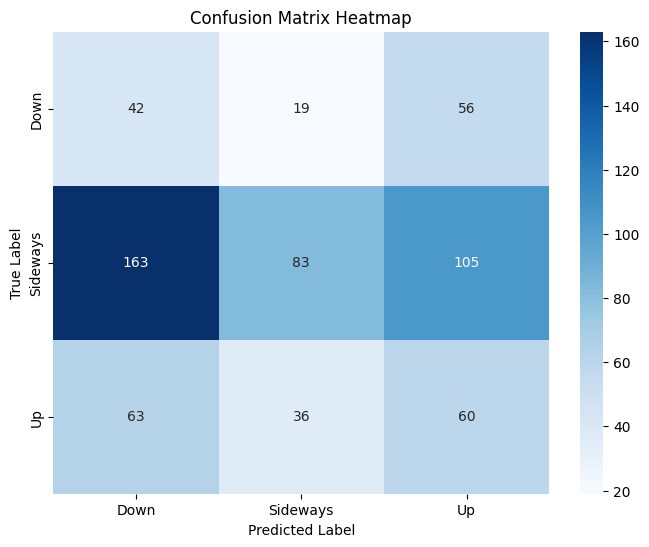

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate the full confusion matrix with all 3 classes
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])  # Ensure all classes included

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Sideways', 'Up'],
            yticklabels=['Down', 'Sideways', 'Up'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


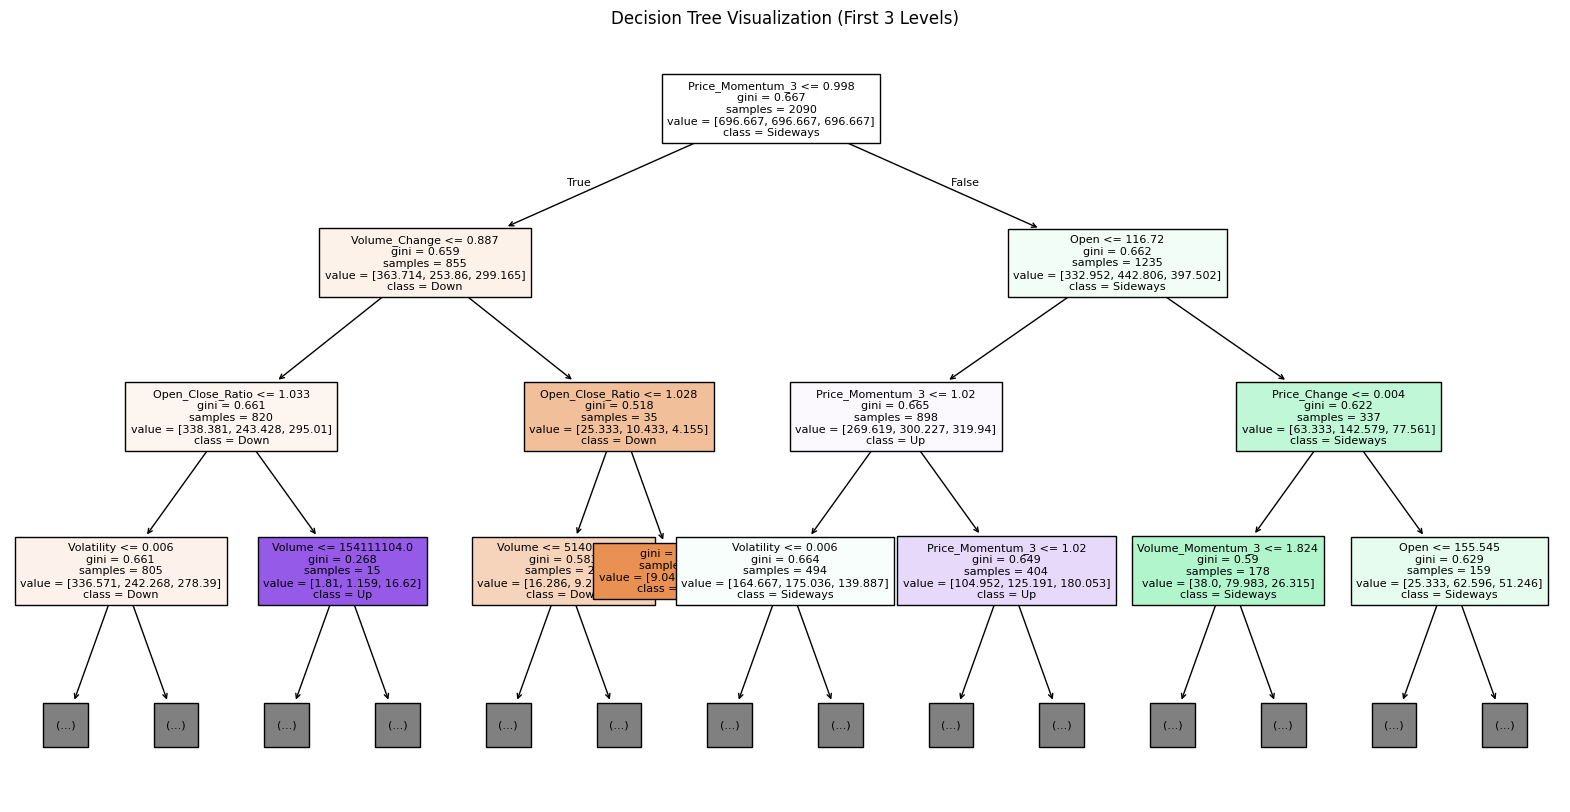

In [13]:
# Decision tree visualization (optional - may be too large)
target_names = ['Down', 'Sideways', 'Up']

try:
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, feature_names=X_train.columns, 
          class_names=[target_names[i] for i in model.classes_],
          fontsize=8, max_depth=3)

    plt.title("Decision Tree Visualization (First 3 Levels)")
    plt.show()
except:
    print("\nDecision tree visualization skipped (tree too large or display issue)")